In [1]:
import sys
sys.path.insert(0, '../')
from nn_cno import ode
import numpy as np
import itertools
import jax.numpy as jnp
import jax
import diffrax
import optax

In [2]:
# load the network 
c = ode.NNODE("../nn_cno/datasets/working_case_study/PKN-test.sif",
    "../nn_cno/datasets/working_case_study/MD-test.csv")

WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
WARNING [absl:335]:  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
c.preprocessing(expansion=False)

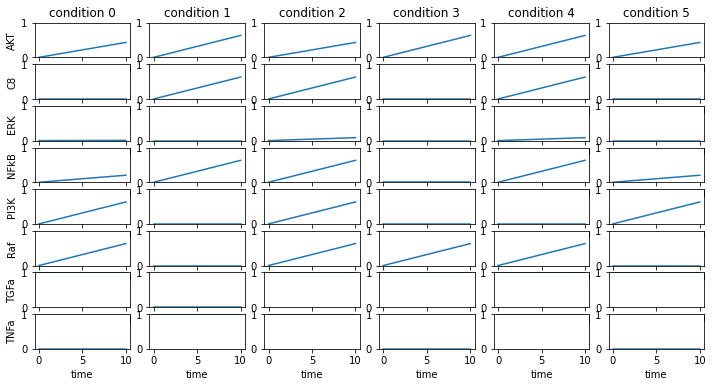

In [4]:
c.plot_simulation(c.simulate(stepsize_controller=diffrax.ConstantStepSize()))

Vmap for conditions: 

In [5]:
parameters = jnp.array(list(c.get_ODEparameters().values()))
sim_conditions = c.conditions


Checking the gradient calculation through the multi-condition setup

In [6]:
# computes the gradient by central finite difference
# evaluates the loss function at p and measured_data
def cfd_grad_loss(model,p,dp=0.01):
    
    ref = p.copy()

    grad = np.zeros((len(p),))

    for i in range(len(p)):
        p_working_p = np.array(ref)
        p_working_n = np.array(ref)
        p_working_p[i] += dp/2
        p_working_n[i] -= dp/2
        forward = model.loss_function(jnp.array(p_working_p))
        backward = model.loss_function(jnp.array(p_working_n))
        grad[i] = (forward - backward) / (dp)
    return(grad)
    

In [7]:
pars = c.get_ODEparameters()
jax_pars = jnp.asarray(list(pars.values()))
grad = cfd_grad_loss(c,jax_pars)

In [8]:
grad

#cfd_grad_loss(c,pars)

array([-0.00836402, -0.00817031,  0.13481528,  0.        ,  0.        ,
       -0.16944855,  0.00378191,  0.00368059,  0.00365376,  0.00328124,
       -0.05428344, -0.0016287 , -0.00156462,  0.        ,  0.        ,
        0.09228885,  0.        ,  0.        ,  0.18647909,  0.        ,
        0.        , -0.06859154])

In [9]:
loss_value, grads = jax.value_and_grad(c.loss_function)(jax_pars)

In [25]:
grads

DeviceArray([-0.00836293, -0.00817067,  0.13509665,  0.        ,
              0.        , -0.1691665 ,  0.00378179,  0.00368012,
              0.00365477,  0.00328091, -0.05427588, -0.00162955,
             -0.00156496,  0.        ,  0.        ,  0.09245268,
              0.        ,  0.        ,  0.18656486,  0.        ,
              0.        , -0.06858799], dtype=float32)

In [26]:
abs(grad- grads) / (abs(grads)+1e-8)

DeviceArray([1.3085162e-04, 4.3997643e-05, 2.0827947e-03, 0.0000000e+00,
             0.0000000e+00, 1.6672872e-03, 3.4107652e-05, 1.2590113e-04,
             2.7482683e-04, 9.9563993e-05, 1.3933147e-04, 5.2236789e-04,
             2.1416406e-04, 0.0000000e+00, 0.0000000e+00, 1.7720503e-03,
             0.0000000e+00, 0.0000000e+00, 4.5973866e-04, 0.0000000e+00,
             0.0000000e+00, 5.1706953e-05], dtype=float32)

In [29]:
c.ODEparameters
loss_value, grads = jax.value_and_grad(c.loss_function)(jax_pars.at[1].set(0.01))
loss_value

  primal = DeviceArray(-0.01935264, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x17d979840>, in_tracers=(Traced<ConcreteArray(1.0003745555877686, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x171010770; to 'JaxprTracer' at 0x1714a09f0>], out_avals=[ShapedArray(float32[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(<lambda>)', 'donated_invars': (False, False), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = mul b a in (c,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x18c186030>, name_stack=NameStack(stack=(Transform(name='jvp'),))))


DeviceArray(0.17338376, dtype=float32)

In [30]:
c.fit(params=jax_pars)

step 0, loss: 0.1511961668729782
	params: [1.0099999  2.01       0.09000007 1.         2.         0.10999993
 0.99000007 1.9900001  0.99000007 1.9900001  0.10999993 1.0099999
 2.0099998  1.         2.         0.09000007 1.         2.
 0.09000007 1.         2.         0.10999993]
step 1, loss: 0.1443222314119339
	params: [1.019936   2.019971   0.08009689 1.         2.         0.11989882
 0.979988   1.9799896  0.9800056  1.9800311  0.11998016 1.0197117
 2.0197775  1.         2.         0.08025719 1.         2.
 0.08002293 1.         2.         0.11995059]
step 2, loss: 0.13863182067871094
	params: [1.0297452  2.0298805  0.07051601 1.         2.         0.12963502
 0.969953   1.9699576  0.970037   1.9701341  0.12991285 1.0289009
 2.0291333  0.99999464 2.         0.07134059 1.         2.
 0.07009028 1.         2.         0.12980066]
step 3, loss: 0.13425719738006592
	params: [1.0393459  2.0396824  0.06185306 1.         2.         0.13915445
 0.95988685 1.9598932  0.9601241  1.960358   0.13

DeviceArray([      nan,       nan,       nan, 1.       , 2.       ,
             0.3432446,       nan,       nan,       nan,       nan,
                   nan,       nan,       nan,       nan,       nan,
                   nan,       nan,       nan,       nan,       nan,
                   nan,       nan], dtype=float32)

In [32]:
my_params =  [ 1.0930372,   2.0984254,   0.0677475,   1. ,         2.,          0.19703364,
  0.88788944,  1.887982,    0.8915032,   1.8949609,   0.20725027,  1.0765575,
  2.0796342,   1.0000834,   2.,          0.08717748 , 1.,          2.,
 -0.00253426,  1. ,         2.,          0.2032137 ]

In [37]:
[l.ys for l in c.simulate(ODEparameters=jnp.asarray(my_params))]

[DeviceArray([[        nan,  0.        ,  0.        ,         nan,
                0.        ,  0.        ,  1.        ,  0.        ],
              [        nan,  0.        ,         nan,         nan,
               -0.02566646,  0.8689262 ,  1.        ,  0.        ]],            dtype=float32, weak_type=True),
 DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ,
               0.        , 0.        , 1.        ],
              [0.49209952, 0.860572  , 0.        , 0.5817866 , 0.        ,
               0.        , 0.        , 1.        ]],            dtype=float32, weak_type=True),
 DeviceArray([[        nan,  0.        ,  0.        ,         nan,
                0.        ,  0.        ,  1.        ,  1.        ],
              [        nan,  0.860572  ,         nan,         nan,
               -0.02566646,  0.8689262 ,  1.        ,  1.        ]],            dtype=float32, weak_type=True),
 DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.        ,

In [14]:

optimizer = optax.adam(learning_rate=1e-2)
params = jax_pars.copy()
opt_state = optimizer.init(params)


In [15]:
opt_state

(ScaleByAdamState(count=DeviceArray(0, dtype=int32), mu=DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0.], dtype=float32), nu=DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0.], dtype=float32)),
 EmptyState())

In [16]:
loss_value, grads = jax.value_and_grad(c.loss_function)(params)
print(loss_value)

0.15119617


In [17]:
updates, opt_state = optimizer.update(grads, opt_state, params)
params = optax.apply_updates(params, updates)
print(params)

[1.0099999  2.01       0.09000007 1.         2.         0.10999993
 0.99000007 1.9900001  0.99000007 1.9900001  0.10999993 1.0099999
 2.0099998  1.         2.         0.09000007 1.         2.
 0.09000007 1.         2.         0.10999993]


In [18]:
print(f'\tparams: {params}')

	params: [1.0099999  2.01       0.09000007 1.         2.         0.10999993
 0.99000007 1.9900001  0.99000007 1.9900001  0.10999993 1.0099999
 2.0099998  1.         2.         0.09000007 1.         2.
 0.09000007 1.         2.         0.10999993]


In [19]:
opt_state

(ScaleByAdamState(count=DeviceArray(1, dtype=int32), mu=DeviceArray([-0.00083629, -0.00081707,  0.01350967,  0.        ,
               0.        , -0.01691665,  0.00037818,  0.00036801,
               0.00036548,  0.00032809, -0.00542759, -0.00016295,
              -0.0001565 ,  0.        ,  0.        ,  0.00924527,
               0.        ,  0.        ,  0.01865649,  0.        ,
               0.        , -0.0068588 ], dtype=float32), nu=DeviceArray([6.99385581e-08, 6.67597888e-08, 1.82511067e-05,
              0.00000000e+00, 0.00000000e+00, 2.86173072e-05,
              1.43019037e-08, 1.35433096e-08, 1.33573383e-08,
              1.07643645e-08, 2.94587107e-06, 2.65542721e-09,
              2.44909093e-09, 0.00000000e+00, 0.00000000e+00,
              8.54749942e-06, 0.00000000e+00, 0.00000000e+00,
              3.48064495e-05, 0.00000000e+00, 0.00000000e+00,
              4.70431223e-06], dtype=float32)),
 EmptyState())

In [20]:
jnp.tan(1*(jnp.pi/2))

DeviceArray(-22877334., dtype=float32, weak_type=True)

In [21]:
k = jnp.zeros((len(params),))
k

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [22]:
k = k.at[0].set(1)
k.at[1].set(2)


DeviceArray([1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [23]:
c.ODEparameters

{'PI3K_k_AKT': 1.0,
 'PI3K_n_AKT': 2.0,
 'tau_AKT': 0.1,
 'TNFa_k_C8': 1.0,
 'TNFa_n_C8': 2.0,
 'tau_C8': 0.1,
 'NFkB_k_ERK': 1.0,
 'NFkB_n_ERK': 2.0,
 'Raf_k_ERK': 1.0,
 'Raf_n_ERK': 2.0,
 'tau_ERK': 0.1,
 'PI3K_k_NFkB': 1.0,
 'PI3K_n_NFkB': 2.0,
 'TNFa_k_NFkB': 1.0,
 'TNFa_n_NFkB': 2.0,
 'tau_NFkB': 0.1,
 'TGFa_k_PI3K': 1.0,
 'TGFa_n_PI3K': 2.0,
 'tau_PI3K': 0.1,
 'TGFa_k_Raf': 1.0,
 'TGFa_n_Raf': 2.0,
 'tau_Raf': 0.1}